In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

##### lists of data in each folder: copy and paste into the cell below
* ./input/  
inputFolderFormat = "./input/{0}"
inputCsvList = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
           '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', '^SSEC.csv', 
           'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv', 
           '0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', 
           '2330.TW.csv', '2409.TW.csv', '2454.TW.csv', '1704.TW.csv']

* ./input/2001_2010/  
inputFolderFormat = "./input/2001_2010/{0}"
inputCsvList = ['QCOM.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
            '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', 
            '^SSEC.csv', 'NSU.DE.csv', 'DAI.DE.csv', 'BMW.DE.csv']  
            
* ./input/fall/  
inputFolderFormat = "./input/fall/{0}"  
inputCsvList = ['1314.TW.csv', '2323.TW.csv', '2349.TW.csv', 
'2353.TW.csv', '2405.TW.csv', '2409.TW.csv', '2601.TW.csv', 
'2885.TW.csv', '2888.TW.csv', '6116.TW.csv']         

In [2]:
inputFolderFormat = "./input/fall/{0}"  
inputCsvList = ['1314.TW.csv', '2323.TW.csv', '2349.TW.csv', 
'2353.TW.csv', '2405.TW.csv', '2409.TW.csv', '2601.TW.csv', 
'2885.TW.csv', '2888.TW.csv', '6116.TW.csv']

inputFolderFormat = "./input/{0}" 
inputCsvList = ['0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', '2330.TW.csv', '2409.TW.csv', '2454.TW.csv',
         '1704.TW.csv']


full_action = True  # if True: buy with all cash, sell all stock
init_invest = 10000
consrange = 20     # consecutive days max. in the prob conslist

conslist = list()
for i in range(0, consrange*2 + 1):
    conslist.append([0, 0])

allrwdlist = list() 
    
for resource_data in inputCsvList:
    
    for i in range(0, consrange*2 + 1):
        conslist[i][0] = 0
        conslist[i][1] = 0
    
    input_csv = inputFolderFormat.format(resource_data)
    data = pd.read_csv(input_csv)
    close = data['Close']
    close = close.fillna(method='ffill')
    close = close.tolist()
    np.isnan(close).any()
    
    rwdlist = list()

    state = {'NumStock': 0, 'StockPrice': close[0], 'HandCash': init_invest}

    cn = 0 # consecutive day num

    for point in range(0, len(close)):
        
        
        if point%45 == 0:
            for i in range(0, consrange*2 + 1):
                conslist.append([0, 0])
        

        state['StockPrice'] = close[point]

        if point == 0:
            cn = 1 # serve as stok price going up
        elif 1 <= cn <= consrange: # consequtive goes up
            if close[point] >= close[point - 1]:
                conslist[cn][0] += 1
                cn += 1
            else:
                conslist[cn][1] += 1
                cn = consrange + 1
        elif consrange+1 <= cn <= consrange*2: # consequtive goes down
            if close[point] < close[point - 1]:
                conslist[cn][1] += 1
                cn += 1
            else:
                conslist[cn][0] += 1
                cn = 1

        tmp = cn

        # ar: action ratio
        while(1):          
            if conslist[tmp][0] + conslist[tmp][1] > 0:
                ar = conslist[tmp][0] / (conslist[tmp][0] + conslist[tmp][1]) # ar: prob of next price going up
                break
            else:
                tmp -= 1
                if tmp == 0 or tmp == consrange:
                    ar = 0.5
                    break

        if ar > 0.5: # next price may go up, let's buy
            ar = (ar - 0.5)*2

            if full_action:
                state['NumStock'] += state['HandCash'] / state['StockPrice']
                state['HandCash'] = 0
            else:
                state['NumStock'] += state['HandCash'] * ar / state['StockPrice']
                state['HandCash'] *= 1 - ar



        else: # next price may go down, let's sell
            ar = 1 - ar # ar: prob of next price going down
            ar = (ar - 0.5)*2

            if full_action:
                state['HandCash'] += state['NumStock'] * state['StockPrice']
                state['NumStock'] = 0
            else:
                state['HandCash'] += state['NumStock'] * ar * state['StockPrice']
                state['NumStock'] *= 1 - ar

        rwdlist.append(state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)
    allrwdlist.append(rwdlist)
                
    print(resource_data, state['HandCash'] + state['StockPrice']*state['NumStock'] - 10000)

0050.TW.csv 3925.1879790325092
1216.TW.csv 7171.988348197272
1301.TW.csv 3348.178478379463
2002.TW.csv -697.7319177867921
2330.TW.csv 11196.144616212365
2409.TW.csv -1676.9383018313838
2454.TW.csv 1685.426615657636
1704.TW.csv 3989.26953640162


#### conslist explanation
* **conslist[1] = [605, 332] ----> stock rose (one day in a row) include today**, in our previous experience, there were 605 days the tomorrow price raise, 332 days the tomorrow price fall
* conslist[2] ----> stock rose two days in a row include today
* ...
* conslist[consrange] ----> stock rose {consrange} days in a row include today
* conslist[consrange + 1] ----> stock fell (one day in a row) include today
* conslist[consrange + 2] ----> stock fell two days in a row include today
* ...
* conslist[consrange*2] ----> stock fell {consrange} days in a row include today
* **conslist[3] = [605, 332] ----> stock rose 3 days in a row include today. In our previous experience, there were 605 days the tomorrow price raise, 332 days the tomorrow price fall in the same situation(i.e. rose 3 days in a row).**

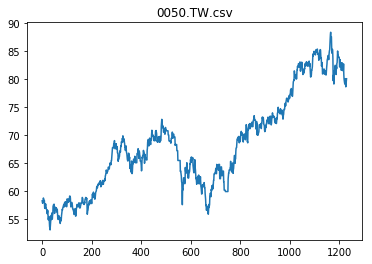

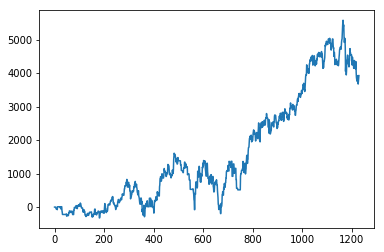

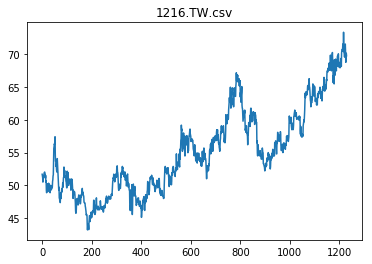

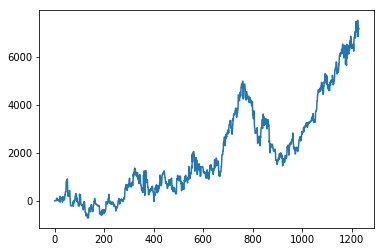

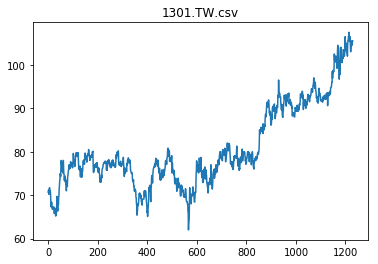

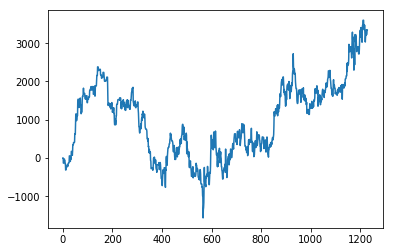

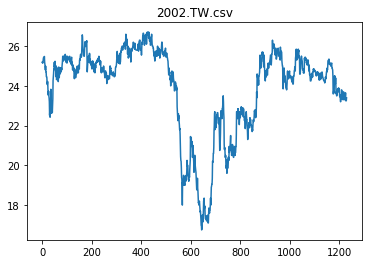

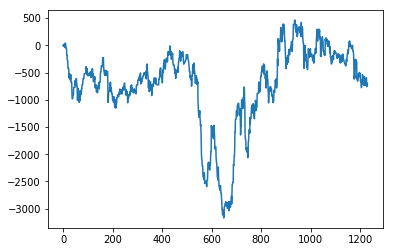

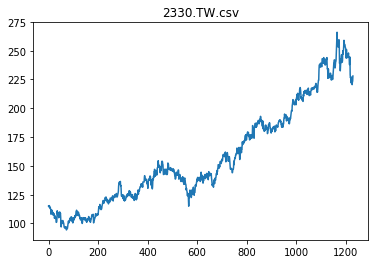

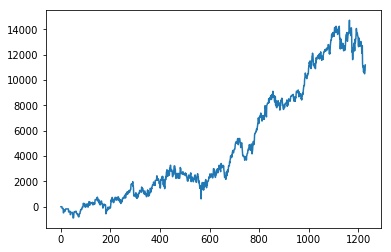

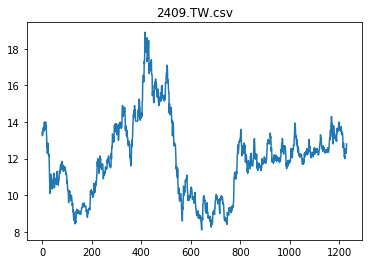

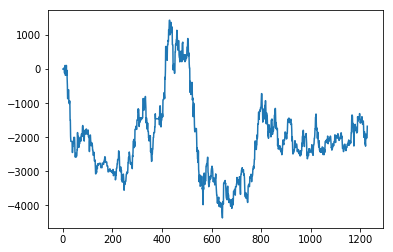

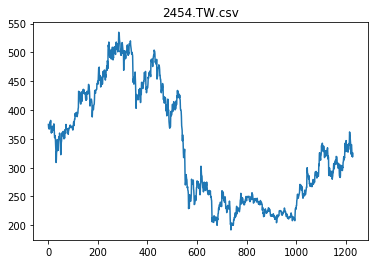

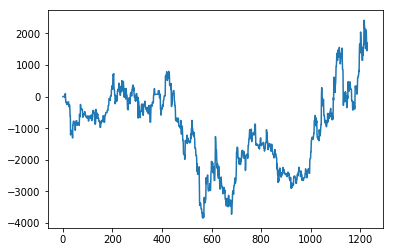

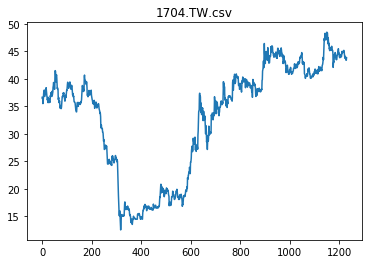

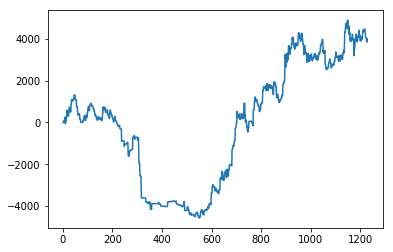

In [3]:
for i in range(0, len(inputCsvList)):
    input_csv = inputFolderFormat.format(inputCsvList[i])
    data = pd.read_csv(input_csv)
    close = data['Close']
    close = close.fillna(method='ffill')
    close = close.tolist()
    plt.title(inputCsvList[i])
    plt.plot(close)
    plt.show()
    plt.plot(allrwdlist[i])
    plt.show()